In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/00-marketing-campaign-data-processing/__results__.html
/kaggle/input/00-marketing-campaign-data-processing/__notebook__.ipynb
/kaggle/input/00-marketing-campaign-data-processing/__output__.json
/kaggle/input/00-marketing-campaign-data-processing/custom.css
/kaggle/input/00-marketing-campaign-data-processing/processed/hypothesis_ready.csv
/kaggle/input/00-marketing-campaign-data-processing/processed/processed.csv
/kaggle/input/00-marketing-campaign-data-processing/processed/processed.pkl
/kaggle/input/arketing-campaign/marketing_campaign.csv
/kaggle/input/arketing-campaign/marketing_campaign.xlsx


<h2>1. Set-up</h2>

In [2]:
IN_PATH = '/kaggle/input/00-marketing-campaign-data-processing/'
HYP_DATA = IN_PATH + 'processed/hypothesis_ready.csv'
df = pd.read_csv(HYP_DATA)
df['Response'] = (df['Response']>0).astype(int)
df.head()

,ID,Year_Birth,Age,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,TotalSpend,AcceptedCnt
0,5524,1957,68,Graduation,Single,58138.0,0,0,2012-09-04,58,...,7,0,0,0,0,0,0,1,1617,0
1,2174,1954,71,Graduation,Single,46344.0,1,1,2014-03-08,38,...,5,0,0,0,0,0,0,0,27,0
2,4141,1965,60,Graduation,Together,71613.0,0,0,2013-08-21,26,...,4,0,0,0,0,0,0,0,776,0
3,6182,1984,41,Graduation,Together,26646.0,1,0,2014-02-10,26,...,6,0,0,0,0,0,0,0,53,0
4,5324,1981,44,PhD,Married,58293.0,1,0,2014-01-19,94,...,5,0,0,0,0,0,0,0,422,0


<h2>2. PSM-ATT | Caliper adjustment</h2>
Adjust Caliper using 20% of standard deviation of propensity score

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from typing import Tuple, List, Optional, Dict
import json

In [16]:
def _standardized_mean_diff(X_t: np.ndarray, X_c: np.ndarray) -> np.ndarray:
    """
    SMD = (mean_t - mean_c) / pooled_std
    """
    mt, mc = X_t.mean(axis=0), X_c.mean(axis=0)
    vt, vc = X_t.var(axis=0, ddof=1), X_c.var(axis=0, ddof=1)
    pooled = np.sqrt((vt + vc) / 2.0 + 1e-12)
    return (mt - mc) / pooled

In [76]:
def psm_att(df: pd.DataFrame, treatment: str, outcome: str, covariates: List[str],
            random_state: int = 42, caliper: Optional[float] = None,
            out_dir: Optional[str] = None, prefix: Optional[str] = None) -> Dict[str, float]:
    """
    dict : {'att','n_pairs','smd_before_mean','smd_after_mean', 'pairs': list}
    """

    X_df = df[covariates].copy()
    
    X = X_df.to_numpy()
    y = df[outcome].to_numpy()
    T = df[treatment].astype(int).to_numpy()

    # Propensity score estimates
    lr = LogisticRegression(max_iter=3000, class_weight=None, n_jobs=None)
    lr.fit(X, T)

    # ps: If this user has features of X, what is the probability that the user responds "yes"
    # P(T=1|X)
    ps = lr.predict_proba(X)[:, 1]
    ps_std = np.std(ps)

    # caliper = 0.2 * ps_std

    # Divide 'Treatment' from 'Control' -> distance based on PS
    idx_t = np.where(T == 1)[0]    # Response=1
    idx_c = np.where(T == 0)[0]    # Response=0
    ps_t, ps_c = ps[idx_t], ps[idx_c]

    nn = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(ps_c.reshape(-1, 1))
    dist, idx = nn.kneighbors(ps_t.reshape(-1, 1), return_distance=True)
    idx = idx.ravel()
    dist = dist.ravel()

    pairs: List[Tuple[int, int]] = []
    for i_t, d, i_c_local in zip(idx_t, dist, idx):
        i_c = idx_c[i_c_local]
        # caliper: if too far
        if caliper is not None and d > caliper:
            continue
        pairs.append((int(i_c), int(i_t)))

    # ATT
    diffs = [y[i_t] - y[i_c] for i_c, i_t in pairs]
    att = float(np.mean(diffs)) if len(diffs) > 0 else float("nan")

    # SMD -> Compare before/after matching
    # if X is a sparse matrix, transform into dense matrix
    def _to_dense(Z):
        return Z.toarray() if hasattr(Z, "toarray") else Z
    X_dense = _to_dense(X)
    
    smd_before = _standardized_mean_diff(X_dense[idx_t], X_dense[idx_c])
    smd_before_mean = float(np.mean(np.abs(smd_before)))
    
    smd_before_detail = {cov: float(smd) for cov, smd in zip(covariates, np.abs(smd_before))}
    
    ps_after = {}
    smd_after_detail = {}
    
    if pairs:
        t_sel = np.array([i_t for _, i_t in pairs])
        c_sel = np.array([i_c for i_c, _ in pairs])
        smd_after = _standardized_mean_diff(X_dense[t_sel], X_dense[c_sel])
        smd_after_mean = float(np.mean(np.abs(smd_after)))

        smd_after_detail = {cov: float(smd) for cov, smd in zip(covariates, np.abs(smd_after))}
        ps_after = {
            "treatment": ps[t_sel].tolist(),
            "control": ps[c_sel].tolist()
        }
    else:
        smd_after_mean = float("nan")

    ps_before = {
        "treatment": ps[idx_t].tolist(),
        "control": ps[idx_c].tolist()
    }

    res = {
        "att": att, "n_pairs": int(len(pairs)),
        "caliper": caliper,
        "smd_before_mean": smd_before_mean,
        "smd_after_mean": smd_after_mean,
        "pairs": pairs[:10],
        "smd_before_detail": smd_before_detail,
        "smd_after_detail": smd_after_detail,
        "ps_before": ps_before,
        "ps_after": ps_after,
    }


    if out_dir is not None and prefix is not None:
        os.makedirs(out_dir, exist_ok=True)
        with open(f"{out_dir}/{prefix}.json", "w", encoding="utf-8") as f:
            json.dump(res, f, ensure_ascii=False, indent=2)

    return res

In [18]:
covariates=['Age', 
            'Income', 
            'Kidhome', 
            'Teenhome', 
            'Recency', 
            'NumWebPurchases',
            'NumCatalogPurchases',
            'NumStorePurchases',
            'NumWebVisitsMonth',
            'NumDealsPurchases',
            'AcceptedCnt'
           ]

In [50]:
treatment='Response' 
outcome='TotalSpend'

X_df = df[covariates].copy()

X = X_df.to_numpy()
y = df[outcome].to_numpy()
T = df[treatment].astype(int).to_numpy()

lr = LogisticRegression(max_iter=3000, class_weight=None, n_jobs=None)
lr.fit(X, T)

ps = lr.predict_proba(X)[:, 1]
ps_std = np.std(ps)

caliper = 0.2 * ps_std

In [77]:
psm_results = psm_att(df=df, treatment=treatment, outcome=outcome, covariates=covariates, caliper=caliper, out_dir='out', prefix='psm_att_report1')

In [21]:
 # print(psm_results)

In [22]:
FIG_PATH = '/kaggle/working/figure'
os.makedirs(FIG_PATH, exist_ok=True)

In [72]:
import matplotlib.pyplot as plt
def smd_plot(results,              
             title: str = 'Covariate Balance: Before & After PSM',
             save_file: Optional[str] = None,
             show_plot: bool = True):
    
    smd_before = results['smd_before_detail']
    smd_after = results['smd_after_detail']
    covariates = list(smd_before.keys())
    y_pos = np.arange(len(covariates))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(smd_before.values(), y_pos, color='red', label=f"Before Matching (mean={results['smd_before_mean']:.3f})", s=80)
    ax.scatter(smd_after.values(), y_pos, color='blue', label=f"After Matching (mean={results['smd_after_mean']:.3f})", s=80)
    
    for i in range(len(covariates)):
        ax.plot([list(smd_before.values())[i], list(smd_after.values())[i]], [y_pos[i], y_pos[i]], color='grey', linestyle='--')
    
    ax.axvline(x=0.1, color='black', linestyle=':', linewidth=1)
    ax.text(0.04, -0.8, '   Balance\nThreshold (0.1)', color='black', fontsize=10)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(covariates)
    ax.invert_yaxis()
    ax.set_xlabel('Standardized Mean Difference (SMD)')
    ax.set_title('Covariate Balance: Before & After PSM', fontsize=16)
    ax.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    if save_file:
        plt.savefig(FIG_PATH + '/'+ save_file, dpi=200, bbox_inches='tight')
        print(f"Plot saved as {save_file}")

    if show_plot:
        plt.show()

Plot saved as smd_caliper_0.2_std_ps.png


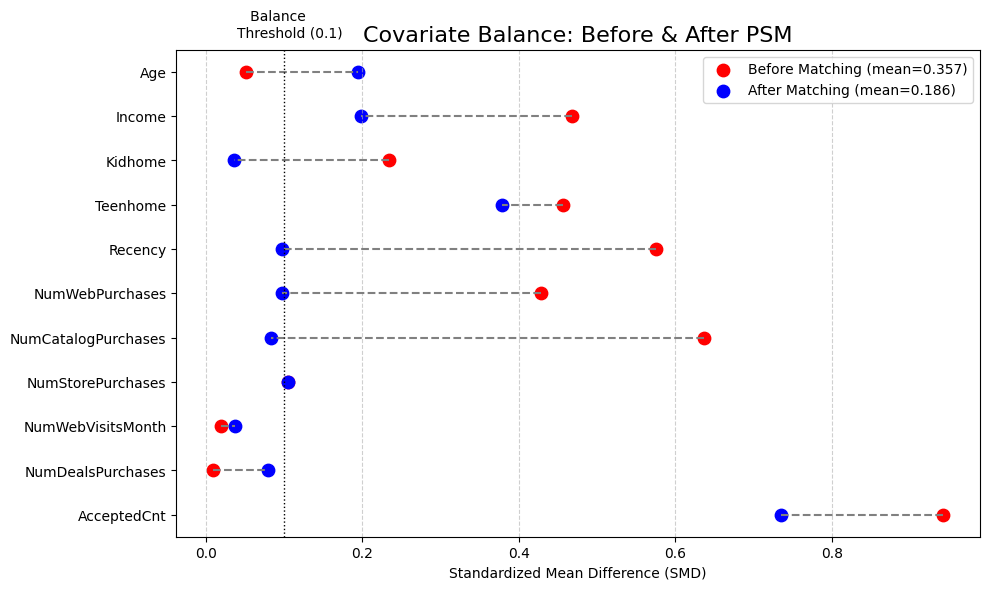

In [73]:
smd_plot(psm_results,              
             title='Covariate Balance: Before & After PSM',
             save_file='smd_caliper_0.2_std_ps.png',
             show_plot=True)

In [25]:
print(psm_results['caliper'])

0.031960240153588615


In [26]:
# Check Caliper
X_df = df[covariates].copy()
X = X_df.to_numpy()
T = df['Response'].astype(int).to_numpy()

lr = LogisticRegression(max_iter=3000)
lr.fit(X, T)
ps = lr.predict_proba(X)[:, 1]

idx_t = np.where(T == 1)[0]
idx_c = np.where(T == 0)[0]
ps_t, ps_c = ps[idx_t], ps[idx_c]

nn = NearestNeighbors(n_neighbors=1).fit(ps_c.reshape(-1, 1))
dist, idx = nn.kneighbors(ps_t.reshape(-1, 1))
dist = dist.ravel()

print(f"(dist.max()): {dist.max()}")
print(f"distance distribution (75%, 80%, 90%): {np.quantile(dist, [0.75, 0.8, 0.9])}")

(dist.max()): 0.01759000765017893
distance distribution (75%, 80%, 90%): [0.00097353 0.00119148 0.00274572]


In [78]:
final_caliper = 0.00274572
psm_results_90_quantile = psm_att(df=df, treatment=treatment, outcome=outcome, covariates=covariates, caliper=final_caliper, out_dir='out', prefix='psm_att_report2')

Plot saved as smd_final_caliper.png


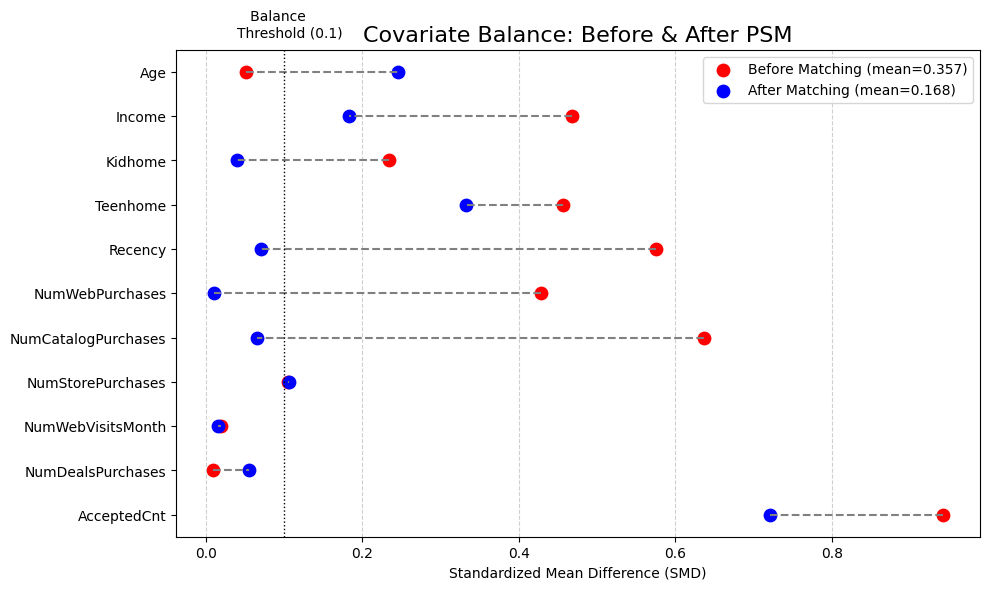

In [75]:
smd_plot(psm_results_90_quantile,              
             title='Covariate Balance: Before & After PSM',
             save_file='smd_final_caliper.png',
             show_plot=True)

<h2>3. PSM-ATT | XGBoost</h2>
Replace Logistic Regression to XGBoost for PS calculation

In [36]:
from xgboost import XGBClassifier

In [79]:
def psm_att_xgboost(df: pd.DataFrame, treatment: str, outcome: str, covariates: List[str],
            random_state: int = 42, caliper: Optional[float] = None,
            out_dir: Optional[str] = None, prefix: Optional[str] = None) -> Dict[str, float]:
    """
    dict : {'att','n_pairs','smd_before_mean','smd_after_mean', 'pairs': list}
    """

    X_df = df[covariates].copy()
    
    X = X_df.to_numpy()
    y = df[outcome].to_numpy()
    T = df[treatment].astype(int).to_numpy()

    # Propensity score estimates
    lr = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, 
                       use_label_encoder=False, eval_metric='logloss', random_state=42)
    lr.fit(X, T)

    # ps: If this user has features of X, what is the probability that the user responds "yes"
    # P(T=1|X)
    ps = lr.predict_proba(X)[:, 1]
    ps_std = np.std(ps)

    # caliper = 0.2 * ps_std

    # Divide 'Treatment' from 'Control' -> distance based on PS
    idx_t = np.where(T == 1)[0]    # Response=1
    idx_c = np.where(T == 0)[0]    # Response=0
    ps_t, ps_c = ps[idx_t], ps[idx_c]

    nn = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(ps_c.reshape(-1, 1))
    dist, idx = nn.kneighbors(ps_t.reshape(-1, 1), return_distance=True)
    idx = idx.ravel()
    dist = dist.ravel()

    pairs: List[Tuple[int, int]] = []
    for i_t, d, i_c_local in zip(idx_t, dist, idx):
        i_c = idx_c[i_c_local]
        # caliper: if too far
        if caliper is not None and d > caliper:
            continue
        pairs.append((int(i_c), int(i_t)))

    # ATT
    diffs = [y[i_t] - y[i_c] for i_c, i_t in pairs]
    att = float(np.mean(diffs)) if len(diffs) > 0 else float("nan")

    # SMD -> Compare before/after matching
    # if X is a sparse matrix, transform into dense matrix
    def _to_dense(Z):
        return Z.toarray() if hasattr(Z, "toarray") else Z
    X_dense = _to_dense(X)
    
    smd_before = _standardized_mean_diff(X_dense[idx_t], X_dense[idx_c])
    smd_before_mean = float(np.mean(np.abs(smd_before)))
    
    smd_before_detail = {cov: float(smd) for cov, smd in zip(covariates, np.abs(smd_before))}
    
    ps_after = {}
    smd_after_detail = {}
    
    if pairs:
        t_sel = np.array([i_t for _, i_t in pairs])
        c_sel = np.array([i_c for i_c, _ in pairs])
        smd_after = _standardized_mean_diff(X_dense[t_sel], X_dense[c_sel])
        smd_after_mean = float(np.mean(np.abs(smd_after)))

        smd_after_detail = {cov: float(smd) for cov, smd in zip(covariates, np.abs(smd_after))}
        ps_after = {
            "treatment": ps[t_sel].tolist(),
            "control": ps[c_sel].tolist()
        }
    else:
        smd_after_mean = float("nan")

    ps_before = {
        "treatment": ps[idx_t].tolist(),
        "control": ps[idx_c].tolist()
    }

    res = {
        "att": att, "n_pairs": int(len(pairs)),
        "caliper": caliper,
        "smd_before_mean": smd_before_mean,
        "smd_after_mean": smd_after_mean,
        "pairs": pairs[:10],
        "smd_before_detail": smd_before_detail,
        "smd_after_detail": smd_after_detail,
        "ps_before": ps_before,
        "ps_after": ps_after,
    }


    if out_dir is not None and prefix is not None:
        os.makedirs(out_dir, exist_ok=True)
        with open(f"{out_dir}/{prefix}.json", "w", encoding="utf-8") as f:
            json.dump(res, f, ensure_ascii=False, indent=2)

    return res

In [80]:
psm_results_xgboost = psm_att_xgboost(df=df, treatment=treatment, outcome=outcome, covariates=covariates, out_dir='out', prefix='psm_att_xgboost1')

Plot saved as smd_xgboost.png


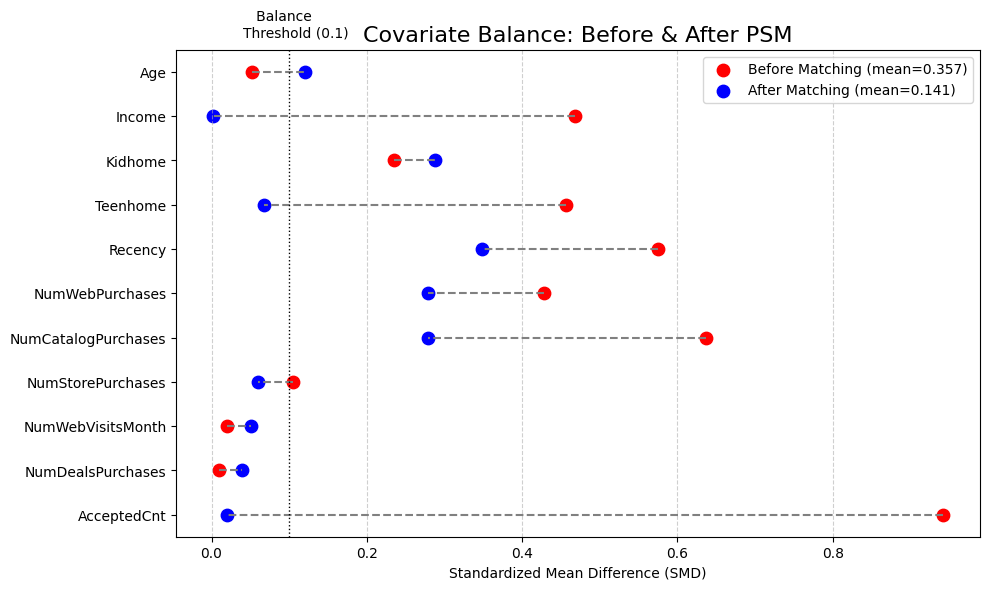

In [91]:
smd_plot(psm_results_xgboost,              
             title='Covariate Balance: Before & After PSM',
             save_file='smd_xgboost.png',
             show_plot=True)

In [83]:
# caliper -> 0.1
psm_results_xgboost_caliper01 = psm_att_xgboost(df=df, treatment=treatment, outcome=outcome, covariates=covariates, caliper=0.1, out_dir='out', prefix='psm_att_xgboost2')

In [86]:
# smd_plot(psm_results_xgboost_caliper01,              
#              title='Covariate Balance: Before & After PSM',
#              save_file='smd_xgboost_caliper01.png',
#              show_plot=True)

In [85]:
# Check Caliper
X_df = df[covariates].copy()
X = X_df.to_numpy()
T = df['Response'].astype(int).to_numpy()

lr = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, 
                    use_label_encoder=False, eval_metric='logloss', random_state=42)
lr.fit(X, T)
ps = lr.predict_proba(X)[:, 1]

idx_t = np.where(T == 1)[0]
idx_c = np.where(T == 0)[0]
ps_t, ps_c = ps[idx_t], ps[idx_c]

nn = NearestNeighbors(n_neighbors=1).fit(ps_c.reshape(-1, 1))
dist, idx = nn.kneighbors(ps_t.reshape(-1, 1))
dist = dist.ravel()

print(f"(dist.max()): {dist.max()}")
print(f"distance distribution (75%, 80%, 90%): {np.quantile(dist, [0.75, 0.8, 0.9])}")

(dist.max()): 0.1790904998779297
distance distribution (75%, 80%, 90%): [0.01632731 0.03017683 0.0998324 ]


In [87]:
# Use 90% caliper
psm_results_xgboost_caliper90 = psm_att_xgboost(df=df, treatment=treatment, outcome=outcome, covariates=covariates, caliper=0.0998324, out_dir='out', prefix='psm_att_xgboost2')

In [90]:
# smd_plot(psm_results_xgboost_caliper90,              
#              title='Covariate Balance: Before & After PSM',
#              save_file='smd_xgboost_caliper90.png',
#              show_plot=True)

<h2>4. PSM-ATT | Hyperparameter Tuning</h2>

In [92]:
from sklearn.model_selection import GridSearchCV

X_df = df[covariates].copy()
X = X_df.to_numpy()
y = df[outcome].to_numpy()
T = df[treatment].astype(int).to_numpy()

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 150],
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X, T)

print(f"\nBest Parameter: {grid_search.best_params_}")
best_xgb_model = grid_search.best_estimator_

ps = best_xgb_model.predict_proba(X)[:, 1]

idx_t = np.where(T == 1)[0]
idx_c = np.where(T == 0)[0]
ps_t, ps_c = ps[idx_t], ps[idx_c]

nn = NearestNeighbors(n_neighbors=1).fit(ps_c.reshape(-1, 1))
dist, idx = nn.kneighbors(ps_t.reshape(-1, 1))
dist = dist.ravel()

final_caliper = np.quantile(dist, 0.9)
print(f"Used Caliper: {final_caliper}")

pairs = []
for i_t, d, i_c_local in zip(idx_t, dist, idx):
    i_c = idx_c[i_c_local]
    if final_caliper is not None and d > final_caliper:
        continue
    pairs.append((int(i_c), int(i_t)))
    
# ATT
diffs = [y[i_t] - y[i_c] for i_c, i_t in pairs]
att = float(np.mean(diffs)) if len(diffs) > 0 else float("nan")

# SMD -> Compare before/after matching
# if X is a sparse matrix, transform into dense matrix
def _to_dense(Z):
    return Z.toarray() if hasattr(Z, "toarray") else Z
X_dense = _to_dense(X)

smd_before = _standardized_mean_diff(X_dense[idx_t], X_dense[idx_c])
smd_before_mean = float(np.mean(np.abs(smd_before)))

smd_before_detail = {cov: float(smd) for cov, smd in zip(covariates, np.abs(smd_before))}

ps_after = {}
smd_after_detail = {}
    
if pairs:
    t_sel = np.array([i_t for _, i_t in pairs])
    c_sel = np.array([i_c for i_c, _ in pairs])
    smd_after = _standardized_mean_diff(X_dense[t_sel], X_dense[c_sel])
    smd_after_mean = float(np.mean(np.abs(smd_after)))
    print(f"\nHyperparameter tuned SMD After Matching: {smd_after_mean:.4f}")

    smd_after_detail = {cov: float(smd) for cov, smd in zip(covariates, np.abs(smd_after))}
    ps_after = {
        "treatment": ps[t_sel].tolist(),
        "control": ps[c_sel].tolist()
    }
else:
    smd_after_mean = float("nan")


ps_before = {
    "treatment": ps[idx_t].tolist(),
    "control": ps[idx_c].tolist()
}

res = {
    "att": att, "n_pairs": int(len(pairs)),
    "caliper": caliper,
    "smd_before_mean": smd_before_mean,
    "smd_after_mean": smd_after_mean,
    "pairs": pairs[:10],
    "smd_before_detail": smd_before_detail,
    "smd_after_detail": smd_after_detail,
    "ps_before": ps_before,
    "ps_after": ps_after,
}


with open("out/psm_att_gridsearch_xgboost.json", "w", encoding="utf-8") as f:
    json.dump(res, f, ensure_ascii=False, indent=2)


Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best Parameter: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}
Used Caliper: 0.18840682506561277

Hyperparameter tuned SMD After Matching: 0.2144


/tmp/ipykernel_36/2473171505.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pairs.append((int(i_c), int(i_t)))


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=150; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=150; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=150; total time=   0.2s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=150; total time=   0.1s
[CV] END ...learning_rate=0.2, max_depth=4, n_estimators=150; total time=   0.1s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.0